In [9]:
import scanpy as sc
import anndata as ad
from pathlib import Path
import pandas as pd

In [16]:
path = Path("../scratch/SpaceHack2/benchmarkJune24/data/visium_hd_cancer_colon_neo/visium_hd_cancer_colon_square_016um/")

In [23]:
pd.read_csv(path / "labels.tsv",sep = "\t",index_col=0)

,label
s_016um_00010_00367-1,Neoplasm
s_016um_00163_00399-1,Neoplasm
s_016um_00238_00388-1,Neoplasm
s_016um_00347_00254-1,Neoplasm
s_016um_00299_00088-1,Neoplasm
...,...
s_016um_00231_00291-1,Neoplasm
s_016um_00202_00345-1,Neoplasm
s_016um_00212_00331-1,Neoplasm
s_016um_00288_00288-1,Neoplasm


In [24]:
def load_spacehack(path):
    adata = ad.io.read_mtx(path / "counts.mtx")
    adata.obsm["spatial"] = pd.read_csv(path / "coordinates.tsv",sep = "\t",index_col=0).values
    adata.obs = pd.read_csv(path / "observations.tsv",sep = "\t",index_col=0)
    adata.var = pd.read_csv(path / "features.tsv",sep = "\t",index_col=0)
    adata.obs["gt"] = pd.read_csv(path / "labels.tsv",sep = "\t",index_col=0).label
    return adata


adata = load_spacehack(path)

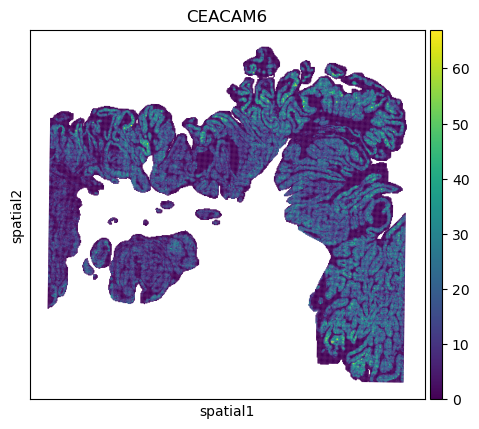

In [30]:
sc.pl.spatial(adata,spot_size =90,color="CEACAM6")

In [58]:
sedr = pd.read_csv("../scratch/SpaceHack2/benchmarkJune24/data/visium_hd_cancer_colon_neo/visium_hd_cancer_colon_square_016um/SEDR/config_default/domains.tsv",sep="\t",index_col=0)
sedr = sedr.rename(columns={"label":"sedr"})
adata.obs = adata.obs.merge(sedr,left_index=True,right_index=True,how="left")
adata.obs.sedr = adata.obs.sedr.astype("category")

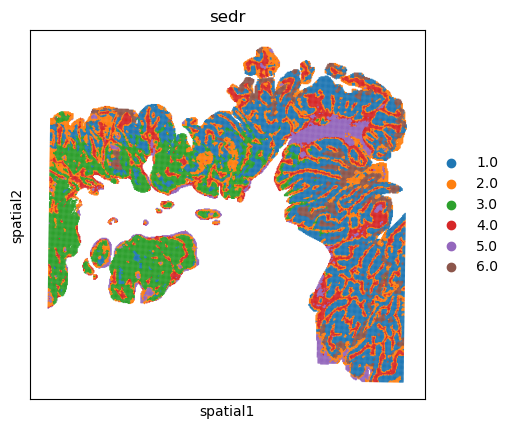

In [69]:
sc.pl.spatial(adata,spot_size =90,color="sedr")

In [63]:
adata = adata[~adata.obs.sedr.isnull()]

In [72]:
adata.obs["sedr"].unique()

[1.0, 4.0, 2.0, 5.0, 3.0, 6.0]
Categories (6, float64): [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

In [73]:
map_dict = {
    
    1.0:"dysplasia",
    2.0:"detritus",
    3.0:"carcinoma",
    4.0:"stroma",
    5.0:"stroma",
    6.0:"unknown"
       
}

adata.obs["sedr_patho"] = adata.obs.sedr.map(map_dict)

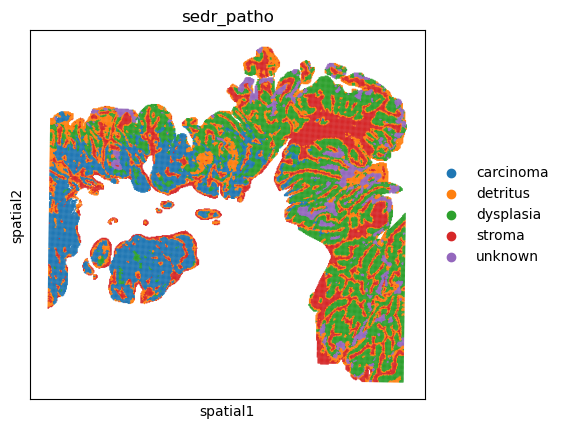

In [74]:
sc.pl.spatial(adata,spot_size =90,color="sedr_patho")

In [75]:
adata.write_h5ad("16um_neoplasm.h5ad")

In [68]:
!run Rscript markers.R --input 16um_neoplasm.h5ad --ct_column sedr_patho --output .

ERROR: Error in parse(text = input): <text>:1:6: unexpected symbol
1: !run Rscript
         ^


In [1]:
# R
library(msigdb)
library(GSEABase)
library(fgsea)
library(data.table)

res = fread("all_genes_ranked_sedr_patho.csv")

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: Biobase

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Loading required package: annotate

Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: IRang

In [44]:
res

feature,group,avgExpr,logFC,statistic,auc,pval,padj,pct_in,pct_out
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SAMD11,carcinoma,0.0005047637,-0.0049372848,501463040,0.4976493,4.547912e-16,1.329814e-15,0.05047637,0.52061215
NOC2L,carcinoma,0.0574168717,-0.0117254551,498894062,0.4950998,5.710235e-06,1.120304e-05,5.53978169,6.51158401
KLHL17,carcinoma,0.0185500663,0.0043158065,505880424,0.5020331,1.582195e-04,2.852841e-04,1.81714935,1.41084320
PLEKHN1,carcinoma,0.0376679917,0.0028294444,505058652,0.5012175,1.292582e-01,1.693569e-01,3.57751278,3.33443433
PERM1,carcinoma,0.0006309546,0.0001905576,503927794,0.5000953,3.263452e-01,3.881331e-01,0.06309546,0.04403970
HES4,carcinoma,0.0066881191,-0.0225668235,493329960,0.4895780,5.062707e-55,3.422769e-54,0.64357373,2.72731562
ISG15,carcinoma,0.0736955013,-0.1067414354,472490847,0.4688974,1.462183e-108,2.053073e-107,6.34740362,12.49154595
AGRN,carcinoma,0.1278314089,-0.0535335072,484921971,0.4812340,7.828329e-33,3.469133e-32,11.75468484,15.38086475
RNF223,carcinoma,0.0039119187,0.0008134114,504257395,0.5004224,9.385658e-02,1.259196e-01,0.39119187,0.30670504


In [85]:
cancer <- setNames(res[group == "carcinoma"][order(-logFC), logFC], 
                   res[group == "carcinoma"][order(-logFC), feature])
dysplasia <- setNames(res[group == "dysplasia"][order(-logFC), logFC], 
                   res[group == "dysplasia"][order(-logFC), feature])

In [88]:
msigdb_hs <- getMsigdb()
msigdb_hs <- subsetCollection(msigdb_hs, c('h', 'c2','c6','c7'))  #  c('h', 'c2', 'c5','c6')
pathways <- geneIds(msigdb_hs)

see ?msigdb and browseVignettes('msigdb') for documentation

loading from cache



In [96]:
cancer_res <- fgsea(pathways = pathways, 
                  stats    = cancer,
                  minSize  = 15,
                  maxSize  = 500)

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (13.07% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


In [97]:
dysplasia_res <- fgsea(pathways = pathways, 
                  stats    = dysplasia,
                  minSize  = 15,
                  maxSize  = 500)

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (12.72% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some of the pathways the P-values were likely overestimated. For such pathways log2err is set to NA.”


In [94]:
fwrite(dysplasia_res[padj<0.05][order(-NES), ],"dysplasia_gsea.csv")

In [95]:
fwrite(cancer_res[padj<0.05][order(-NES), ],"cancer_gsea.csv")